In [ ]:
#!pip install -q transformers datasets evaluate

In [ ]:
#!pip install ipywidgets
#!pip install huggingface_hub
#!pip install matplotlib
#!pip install opencv-python
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install lightning

### Login into huggingface

In [31]:
from huggingface_hub import notebook_login
notebook_login()

# GPU Config

### Check for free gpu to use for parallel computing

In [1]:
import subprocess

# Run nvidia-smi command
result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

Wed Apr  3 14:50:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000                On | 00000000:01:00.0 Off |                    0 |
| 52%   76C    P2              108W / 230W|  13243MiB / 23028MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### The Dataset is created by cropping the original images and labels into a size of (640x640). These crop images are then split into train test and val respectively based on ratio of (0.6, 0.2 and 0.2) respectively.

# Data Augmentation

In [2]:
#pip install -U albumentations

In [43]:
import albumentations as A

In [44]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if not f.startswith('.')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx] + '.jpg')
        mask_path = os.path.join(self.masks_dir, self.filenames[idx] + '.png') 
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") 
        batch={"pixel_values": image, 
               "labels": mask
              }
        if self.transform:
            batch = self.transform(batch)
            for k,v in batch.items():
                batch[k].squeeze_() # remove batch dimension
                v[v==255]=1
                
        return batch

In [45]:
images_dir = "metalchip_dataset/images/train"
masks_dir = "metalchip_dataset/labels/train"
train_ds = ImageSegmentationDataset(images_dir, masks_dir)

In [46]:
image=train_ds[5]['pixel_values']
label=train_ds[5]['labels']

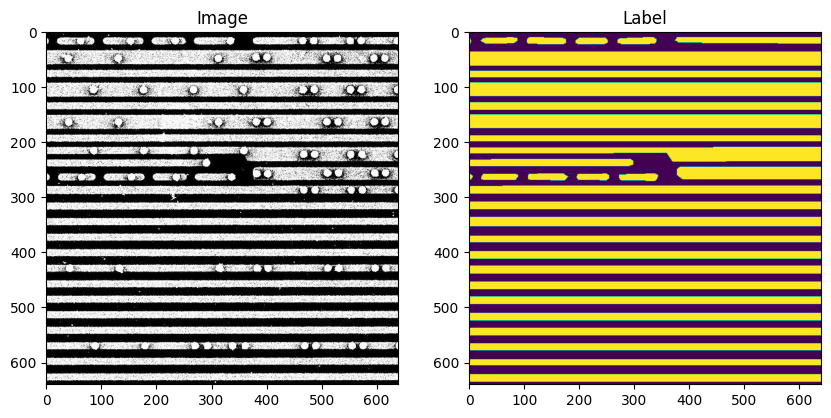

In [47]:
import matplotlib.pyplot as plt

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Label')
plt.imshow(label)

plt.show()

In [48]:
import numpy as np

np_image = np.array(image)
np_label = np.array(label)

In [49]:
# Define the transformation
HFlip = A.Compose([
    A.HorizontalFlip(p=1),  
])
# Define the transformation
VFlip = A.Compose([
    A.VerticalFlip(p=1),  
])
CJ = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.7, hue=0.2, p=1),
])

## Horizontal Flip

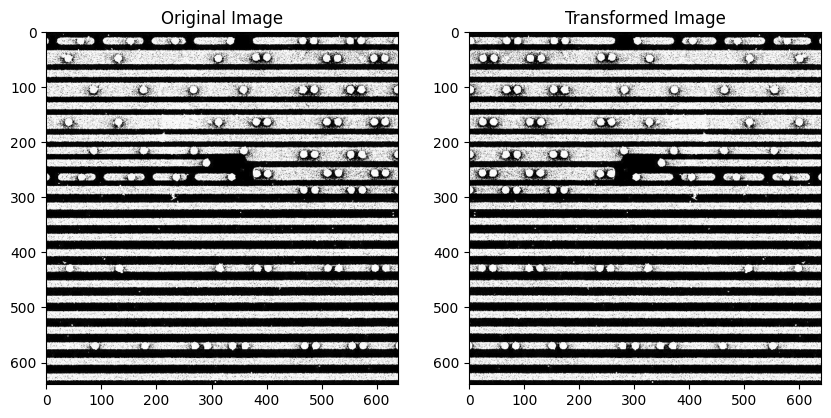

In [50]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = HFlip(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

## Vertical Flip

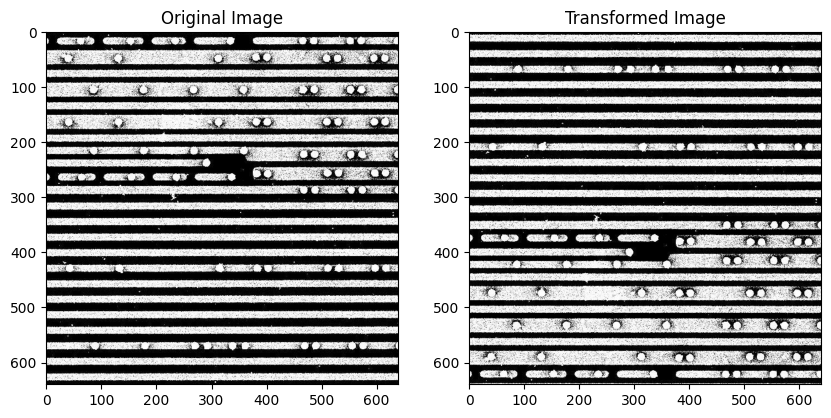

In [51]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = VFlip(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

## ColorJitter 

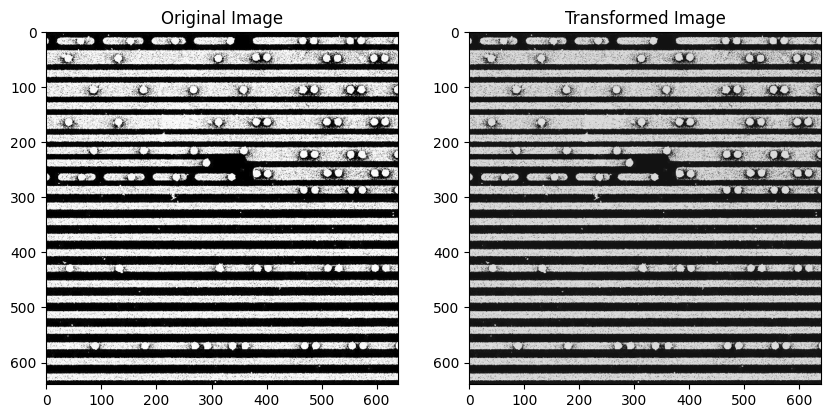

In [52]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = CJ(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

# Load Dataset

### Create dataset dict with the images and labels

### The Dataset dict is created by passing in the image directory as well as the labels directory. Images are in jpg format while the labels are in png format. The dataset entries can be accessed by indexing e.g. dataset[idx]. For each entries, there are two items, np_images and, np_labels. The image is transposed to convert it into [Channel, Height, Width] format. The label's values are also converted from 255 to 1 in order to match the output from argmax from the model's prediction later.
### To access np_images, dataset[idx][0]. 
### To access np_labels, dataset[idx][1].

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader 
import torch
torch.manual_seed(1)

class ImageSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if not f.startswith('.')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx] + '.jpg')
        mask_path = os.path.join(self.masks_dir, self.filenames[idx] + '.png') 
        image = Image.open(img_path).convert("RGB")
        np_image=np.array(image)
        # convert to C, H, W
        np_image = np_image.transpose(2,0,1)
        mask = Image.open(mask_path) 
        np_mask=np.array(mask)
        np_mask[np_mask==255]=1
      
        return np_image, np_mask

# Defining Data Module from pytorch lightning

### collate_fn is used to process the images and label using SegformerImageProcessor. SegformerImageProcessor normalizes the input using ImageNet mean = (0.485, 0.456, 0.406) and std = (0.229, 0.224, 0.225) and then convert it to tensor.
 
### The output is pixel_values, a batch of images with size (2, 3, 640, 640) and labels, a batch of pixel_masks of size (2, 640, 640) for each batch. 

In [2]:
def collate_fn(batch):
    inputs = list(zip(*batch))
    images=inputs[0]
    segmentation_maps=inputs[1]
    batch = processor(
        images,
        segmentation_maps=segmentation_maps,
        size=(640,640),
        return_tensors="pt",
    )
    return batch

In [3]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, dataset_dir, batch_size, num_workers, processor=None):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.processor = processor
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'train'),
                                                          masks_dir=os.path.join(self.dataset_dir, 'labels', 'train'),
                                                          transform=None) # Add your transforms here
            self.val_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'val'),
                                                        masks_dir=os.path.join(self.dataset_dir, 'labels', 'val'),
                                                        transform=None) # Add your transforms here
        if stage == 'test' or stage is None:
            self.test_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'test'),
                                                         masks_dir=os.path.join(self.dataset_dir, 'labels', 'test'),
                                                         transform=None) # Add your transforms here
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)

In [4]:
from transformers import SegformerImageProcessor

processor = SegformerImageProcessor()

In [5]:
batch_size=1
num_workers=4

data_module = SegmentationDataModule(dataset_dir='data_augmentation_dataset', batch_size=batch_size, num_workers=num_workers, processor=processor)

In [6]:
data_module.setup(stage='fit')
train_dataloader = data_module.train_dataloader()

In [7]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 640, 640])
labels torch.Size([1, 640, 640])


### Creating id for the class

In [8]:
newid2label={
    0: 'Background',
    1: 'Metal Lines'
}
newid2label

{0: 'Background', 1: 'Metal Lines'}

In [9]:
newlabel2id = {v: k for k, v in newid2label.items()}
newlabel2id

{'Background': 0, 'Metal Lines': 1}

In [10]:
num_labels = len(newlabel2id)
num_labels

2

# Training 

In [11]:
from transformers import SegformerForSemanticSegmentation
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics import Metric
from datasets import load_metric
from torch import nn
import random
import torch
torch.set_float32_matmul_precision("medium")
import evaluate
import time
import json 

## Defining Pytorch Lightning Module

### The output from segformer is H/4 x W/4, hence there is a need to interpolate to resize the image back to its original size.

In [12]:
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, id2label):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            return_dict=False,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        evaluate.load
        self.train_mean_iou = evaluate.load("mean_iou")
        self.val_mean_iou = evaluate.load("mean_iou")
        self.test_mean_iou = evaluate.load("mean_iou")

    def forward(self, pixel_values, labels):
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        return(outputs)
    '''
    def transfer_batch_to_device(self, batch, device, dataloader_idx=0):
        batch['pixel_values'] = batch['pixel_values'].to(device)
        batch['labels'] = batch['labels'].to(device)
        return batch
    '''
    def on_train_start(self):
        self.start_time = time.time()

    def on_train_end(self):
        total_time = time.time() - self.start_time
        metrics = {'final_epoch': self.current_epoch, 'training_time': total_time}
        with open('segformer_hyperparameters.json', 'w') as f:
            json.dump(metrics, f)

    def training_step(self, batch, batch_idx):
        images, masks = batch['pixel_values'], batch['labels']
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)
        metrics = self.train_mean_iou._compute(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy(),
            num_labels=self.num_classes,
            ignore_index=254,
            reduce_labels=False,
        )
        # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()
    
        # Re-define metrics dict to include per-category metrics directly
        metrics = {
            'loss': loss, 
            "mean_iou": metrics["mean_iou"], 
            "mean_accuracy": metrics["mean_accuracy"],
            **{f"accuracy_{self.id2label[i]}": v for i, v in enumerate(per_category_accuracy)},
            **{f"iou_{self.id2label[i]}": v for i, v in enumerate(per_category_iou)}
        }
        for k,v in metrics.items():
            self.log(k,v,sync_dist=True, on_epoch=True, logger=True)
        return(metrics)

    def validation_step(self, batch, batch_idx):
        images, masks = batch['pixel_values'], batch['labels']
        outputs = self(images, masks)   
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks[0].shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)
        metrics = self.val_mean_iou._compute(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy(),
            num_labels=self.num_classes,
            ignore_index=254,
            reduce_labels=False,
        )
        # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()
    
        # Re-define metrics dict to include per-category metrics directly
        metrics = {
            'loss': loss, 
            "mean_iou": metrics["mean_iou"], 
            "mean_accuracy": metrics["mean_accuracy"],
            **{f"accuracy_{self.id2label[i]}": v for i, v in enumerate(per_category_accuracy)},
            **{f"iou_{self.id2label[i]}": v for i, v in enumerate(per_category_iou)}
        }
        for k,v in metrics.items():
            self.log(k,v,sync_dist=True)
        return(metrics)
        
    def test_step(self, batch, batch_idx):
        images, masks = batch['pixel_values'], batch['labels']
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)
        metrics = self.test_mean_iou._compute(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy(),
            num_labels=self.num_classes,
            ignore_index=254,
            reduce_labels=False,
        )
        # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()
    
        # Re-define metrics dict to include per-category metrics directly
        metrics = {
            'loss': loss, 
            "mean_iou": metrics["mean_iou"], 
            "mean_accuracy": metrics["mean_accuracy"],
            **{f"accuracy_{self.id2label[i]}": v for i, v in enumerate(per_category_accuracy)},
            **{f"iou_{self.id2label[i]}": v for i, v in enumerate(per_category_iou)}
        }
        for k,v in metrics.items():
            self.log(k,v,sync_dist=True)
        return(metrics)
        
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=0.001)

## Initialising Model

In [33]:
model=SegformerFinetuner(newid2label)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load previously trained model

In [13]:
path="segformer_checkpoint_hyperparameters.ckpt"
model = SegformerFinetuner.load_from_checkpoint(path,id2label=newid2label)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining early stopping and to load the best model from checkpoint

In [17]:
early_stop_callback = EarlyStopping(
    monitor="loss",
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, 
                                      monitor="loss", 
                                      every_n_epochs=1,  # Save the model at every epoch 
                                      save_on_train_epoch_end=True  # Ensure saving happens at the end of a training epoch
                                     )

### Use tensorboard to log outputs

In [67]:
#pip install -U 'tensorboard'

In [68]:
logger=TensorBoardLogger("tb_logger",name="segformer_lightning_v2")

In [16]:
logger_csv = pl.loggers.CSVLogger("outputs", name="lightning_logs_csv")

## Training the model

In [20]:
trainer = pl.Trainer(
    logger=logger_csv,
    strategy="ddp_notebook",
    accelerator='gpu',
    devices=[1,2,3],
    precision="16-mixed",
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=1
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model,data_module)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M 
-----------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[rank: 0] Metric loss improved. New best score: 0.065
[rank: 2] Metric loss improved. New best score: 0.065
[rank: 1] Metric loss improved. New best score: 0.065
`Trainer.fit` stopped: `max_epochs=1` reached.


In [17]:
trainer = pl.Trainer(
    logger=logger_csv,
    devices=1,
    num_nodes=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Set to only use one GPU for validation and testing.

In [22]:
trainer.validate(model, data_module)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/internroyce/anaconda3/envs/segformer-lightning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:232: Using `DistributedSampler` with the dataloaders. During `trainer.validate()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that rep

Validation: |                                                                                     | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy_Background      0.9585801959037781
  accuracy_Metal Lines      0.9624919295310974
     iou_Background         0.9159678816795349
     iou_Metal Lines        0.9305976629257202
          loss              0.10272299498319626
      mean_accuracy         0.9605361223220825
        mean_iou            0.9232826828956604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss': 0.10272299498319626,
  'mean_iou': 0.9232826828956604,
  'mean_accuracy': 0.9605361223220825,
  'accuracy_Background': 0.9585801959037781,
  'accuracy_Metal Lines': 0.9624919295310974,
  'iou_Background': 0.9159678816795349,
  'iou_Metal Lines': 0.9305976629257202}]

In [18]:
trainer.test(model, data_module) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy_Background      0.9746884107589722
  accuracy_Metal Lines      0.9771897792816162
     iou_Background         0.9495560526847839
     iou_Metal Lines        0.9575091600418091
          loss              0.13896486163139343
      mean_accuracy         0.9759387969970703
        mean_iou            0.9535326361656189
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss': 0.13896486163139343,
  'mean_iou': 0.9535326361656189,
  'mean_accuracy': 0.9759387969970703,
  'accuracy_Background': 0.9746884107589722,
  'accuracy_Metal Lines': 0.9771897792816162,
  'iou_Background': 0.9495560526847839,
  'iou_Metal Lines': 0.9575091600418091}]

### Save model

In [23]:
trainer.save_checkpoint("segformer_checkpoint_7Mar.ckpt")

# Test model performance

In [83]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [84]:
%tensorboard --logdir /Users/royceteng/Downloads/tb_logger/segformer_lightning_v0/version_0

Reusing TensorBoard on port 6007 (pid 3681828), started 0:00:14 ago. (Use '!kill 3681828' to kill it.)

In [85]:
!kill 3681828

In [14]:
model.eval()

SegformerFinetuner(
  (model): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (la

In [15]:
batch = next(iter(train_dataloader))
batch

{'pixel_values': tensor([[[[-2.0152, -1.1247, -1.6727,  ...,  1.7865,  2.2489,  2.0092],
          [-2.1179, -1.9638, -2.0494,  ..., -1.7925, -0.7993, -1.8097],
          [-1.8782, -2.0665, -2.1179,  ..., -2.1179, -2.0152, -1.9809],
          ...,
          [-2.1179, -1.8439, -2.1179,  ..., -2.1179, -2.0494, -2.0152],
          [-2.0665, -1.9124, -2.0494,  ..., -1.9980, -2.0837, -2.1008],
          [-2.0665, -2.1179, -2.0323,  ..., -2.1179, -2.1179, -2.0494]],

         [[-1.9307, -1.0203, -1.5805,  ...,  1.9559,  2.4286,  2.1835],
          [-2.0357, -1.8782, -1.9657,  ..., -1.7031, -0.6877, -1.7206],
          [-1.7906, -1.9832, -2.0357,  ..., -2.0357, -1.9307, -1.8957],
          ...,
          [-2.0357, -1.7556, -2.0357,  ..., -2.0357, -1.9657, -1.9307],
          [-1.9832, -1.8256, -1.9657,  ..., -1.9132, -2.0007, -2.0182],
          [-1.9832, -2.0357, -1.9482,  ..., -2.0357, -2.0357, -1.9657]],

         [[-1.6999, -0.7936, -1.3513,  ...,  2.1694,  2.6400,  2.3960],
          [-1

In [16]:
# Batch size=1
images = batch["pixel_values"]
labels=batch["labels"]

### Define color palette

In [17]:
def color_palette():
    #Define positive as metal line and negative as background
    return [
        [0, 0, 0], #background, True negative (Black)
        [77, 175, 74], #True positive, metal line predicted as metal line (green)
        [228, 26, 28], #False negative, metal line predicted as background (red)
        [55, 126, 184], #False positve, background predicted as metal line (blue)
    ]

In [18]:
def apply_palette(label, palette):
    # Create an empty array to store the RGB values
    colored_label = np.zeros((*label.shape, 3), dtype=np.uint8)
    
    # Map each class to its corresponding color
    for class_index, color in enumerate(palette):
        mask = label == class_index
        colored_label[mask] = color
    
    return colored_label

### Function to view mask

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def viewMask(image,label):
    # Need to convert image and labels to numpy to plot.
    image=image.numpy()
    # Plot expects (height, width, channels), hence transpose.
    image_transpose = np.transpose(image, (1, 2, 0))
    label=label.numpy()
    palette = color_palette()
    colored_label = apply_palette(label, palette)
    
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Image", {'fontsize': 40})
    axs[0].imshow(image_transpose)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(colored_label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


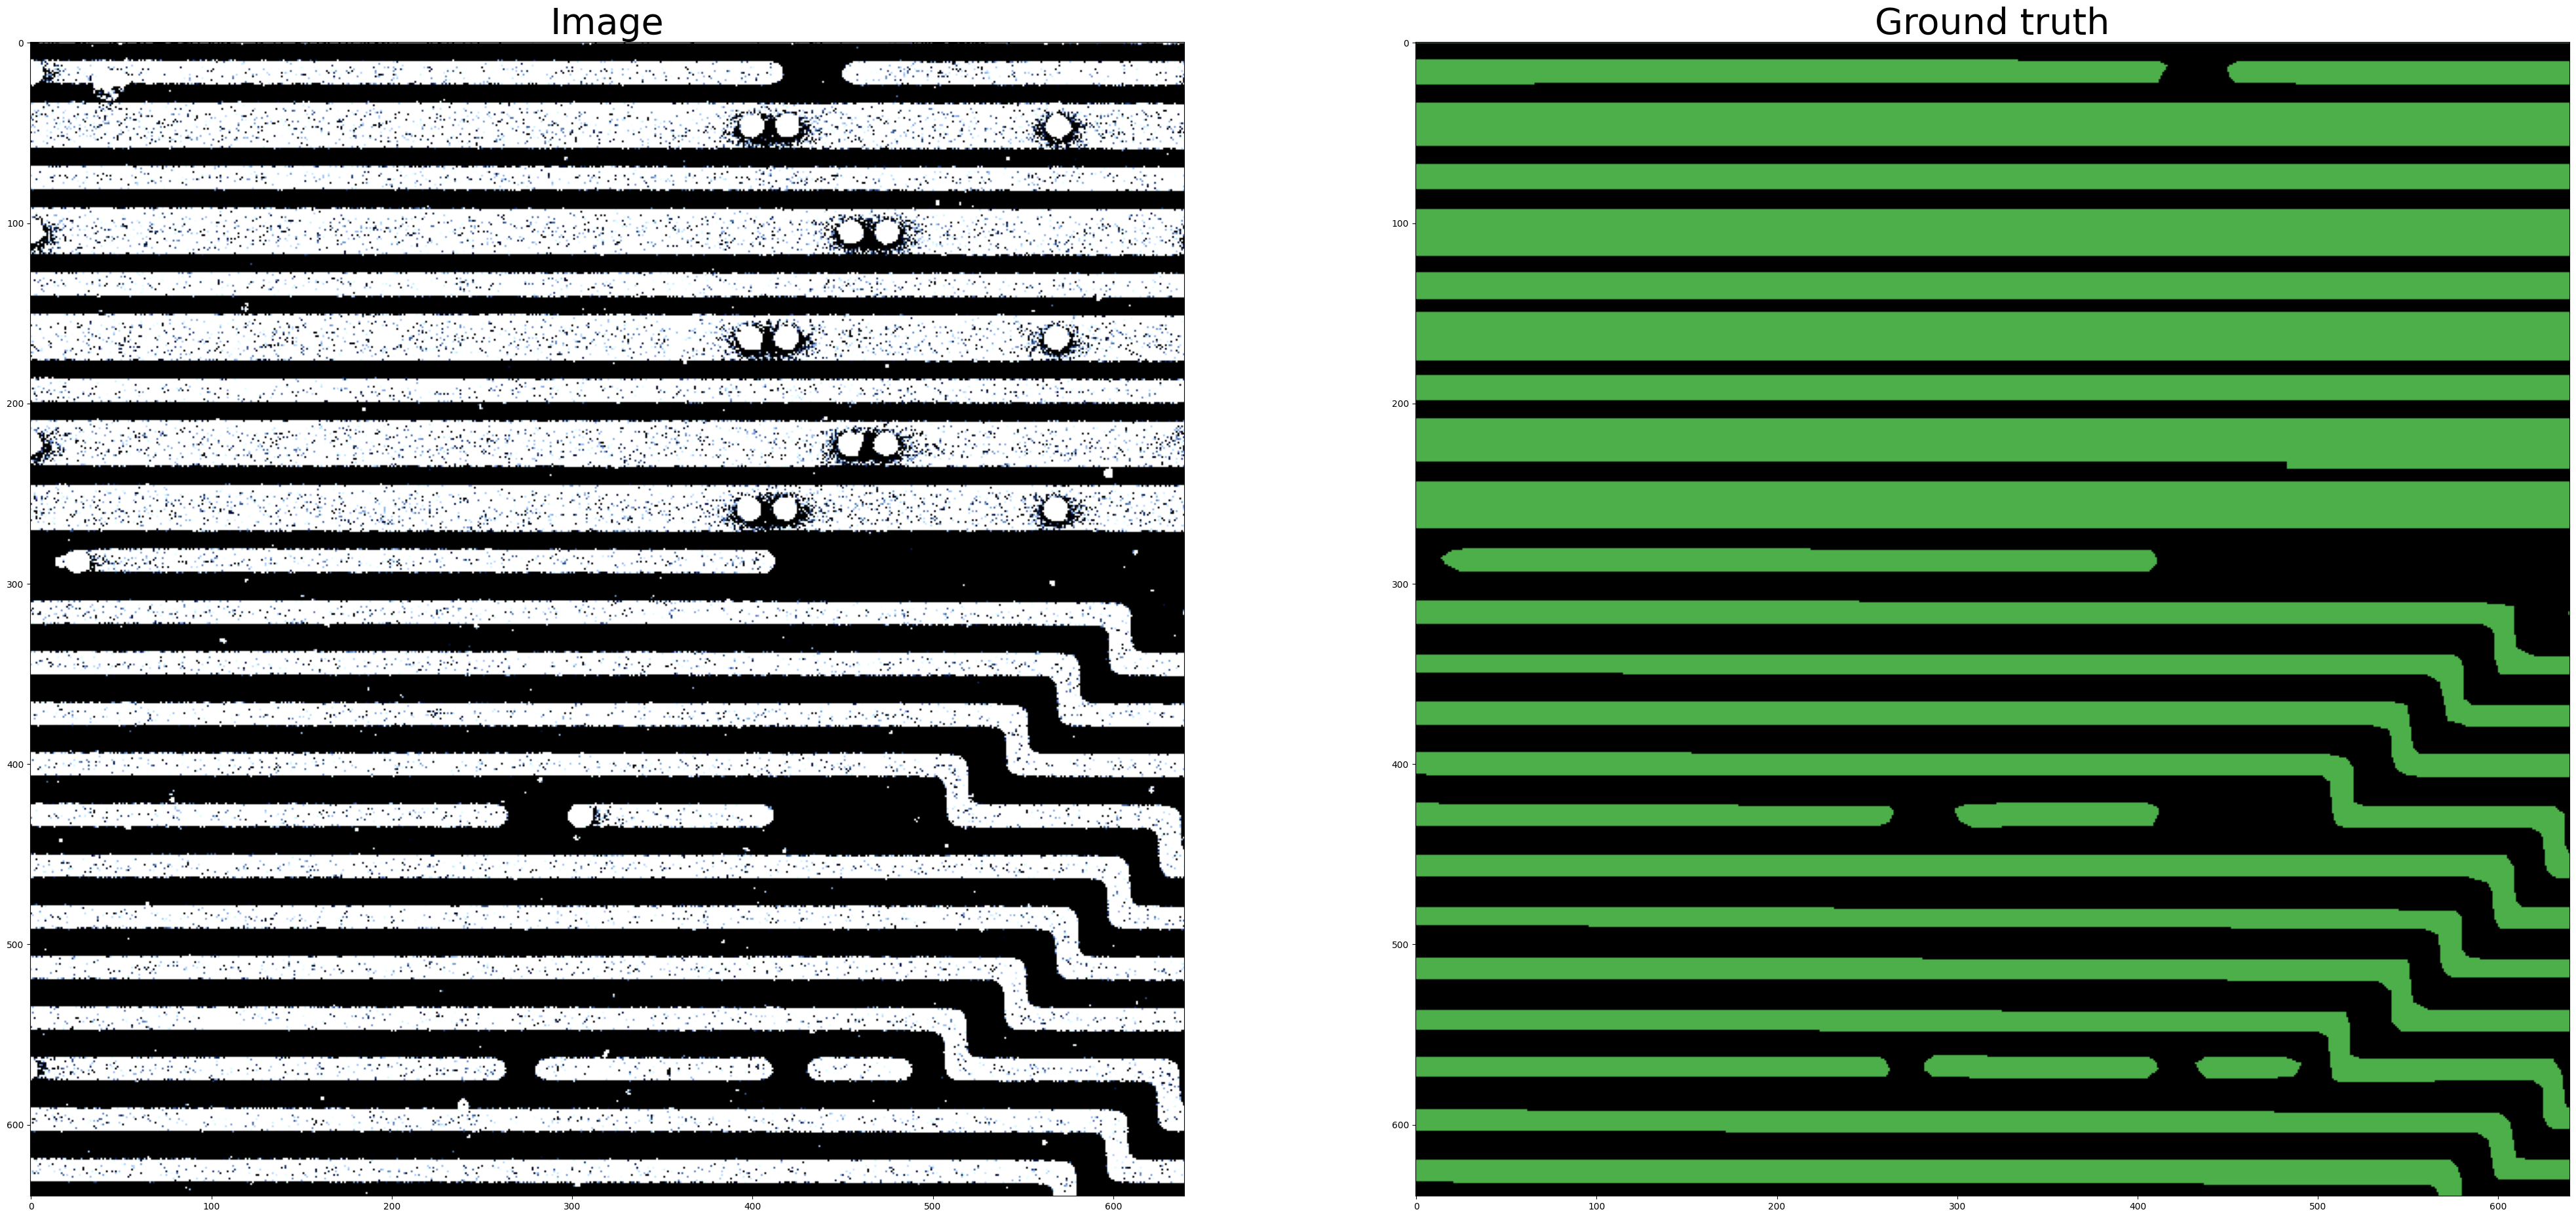

In [20]:
viewMask(images[0],labels[0])

### Function to do predictions for a batch

In [21]:
def batch_prediction(images, labels):
    outputs = model(images, labels)
    loss, logits = outputs[0], outputs[1]
    upsampled_logits = nn.functional.interpolate(
        logits,
        #size of original image is 640x640
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).numpy()
    labels = labels.numpy()
    return predicted_mask, labels

In [22]:
pred_images, gt_labels =batch_prediction(images,labels)

### Define a function to display a prediction overlay in which blue represents correct prediction while red represent in correct prediction

#### Black means TN (background), Green means TP (metal-line), Red means FN (metal-line as background), Blue means FP (background as metal-line)

In [23]:
def wrongPredictionOverlay(image,label):
        # Initialize the new array with the same shape as the prediction and label arrays
    new_array = np.zeros_like(image)
    new_array[(image == 0) & (label == 0)] = 0
    new_array[(image == 1) & (label == 1)] = 1
    new_array[(image == 0) & (label == 1)] = 2
    new_array[(image == 1) & (label == 0)] = 3
    palette = color_palette()
    colored_array = apply_palette(new_array[0], palette)
    colored_label = apply_palette(label[0], palette)
    
    # Display the original and transformed images
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Prediction overlay", {'fontsize': 40})
    axs[0].imshow(colored_array)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(colored_label)

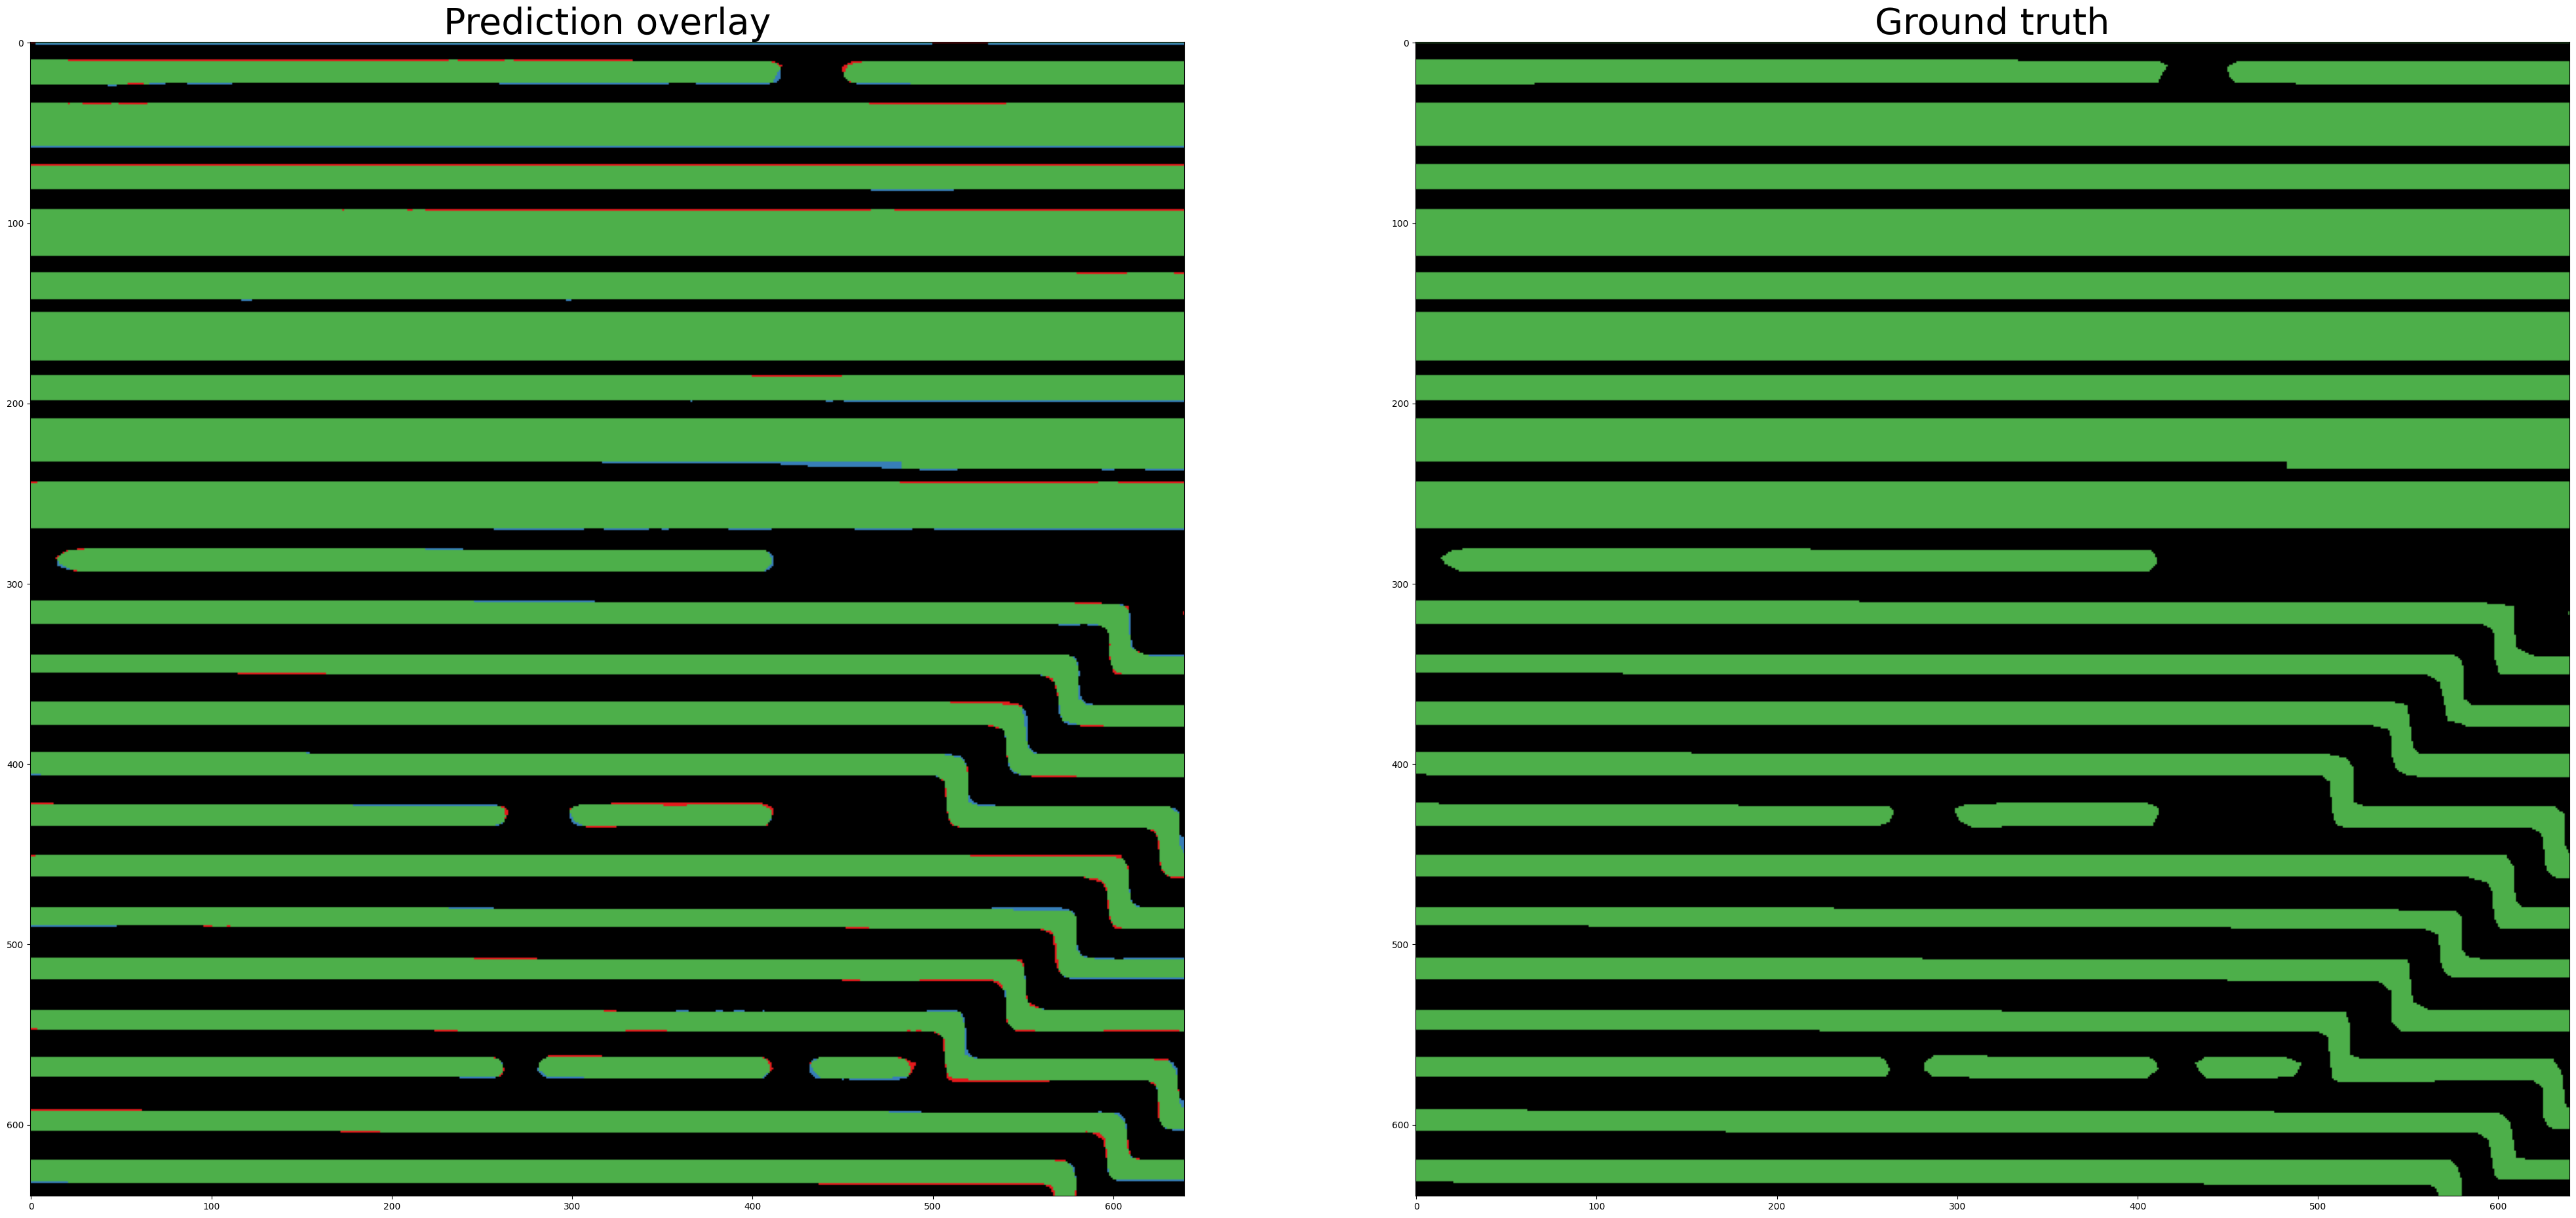

In [24]:
wrongPredictionOverlay(pred_images,gt_labels)

### Function to compute Miou for single image

In [25]:
def miou(pred,label):
    #pred and label must be array, both of size (640,640)
    predictions = pred
    references = label
    
    # Ensure they are of type uint16
    predictions_uint16 = predictions.astype(np.uint16)
    references_uint16 = references.astype(np.uint16)
    
    # Wrap each in an additional list to match the expected "sequence of sequences" structure
    predictions_formatted = [predictions_uint16.tolist()]
    references_formatted = [references_uint16.tolist()]

    # Calculate FN and FP
    false_negatives = np.sum((pred == 0) & (label == 1))
    false_positives = np.sum((pred == 1) & (label == 0))
    
    # Total number of instances
    total_instances = np.prod(pred.shape)
    
    # Calculate percentages
    percentage_fn = (false_negatives / total_instances) * 100
    percentage_fp = (false_positives / total_instances) * 100
    
    metric = evaluate.load("mean_iou")
    # Now your data should match the expected format:
    metrics = metric._compute(
        predictions=predictions_formatted,
        references=references_formatted,
        num_labels=len(newlabel2id),
        ignore_index=254
    )
      # add per category metrics as individual key-value pairs
    # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    # Re-define metrics dict to include per-category metrics directly
    metrics = {
        "mean_iou": metrics["mean_iou"], 
        "mean_accuracy": metrics["mean_accuracy"],
        "False Negative": f"{percentage_fn:.2f}%",
        "False Positive": f"{percentage_fp:.2f}%",
        **{f"accuracy_{newid2label[i]}": v for i, v in enumerate(per_category_accuracy)},
        **{f"iou_{newid2label[i]}": v for i, v in enumerate(per_category_iou)}
    }
    
    return metrics

In [26]:
miou(pred_images[0],gt_labels[0])

{'mean_iou': 0.969779790006495,
 'mean_accuracy': 0.9846306921638829,
 'False Negative': '0.72%',
 'False Positive': '0.81%',
 'accuracy_Background': 0.9832414331394617,
 'accuracy_Metal Lines': 0.9860199511883041,
 'iou_Background': 0.9688490832857817,
 'iou_Metal Lines': 0.9707104967272082}

### Function to see prediction for a batch of images

In [27]:
def viewBatchPredictions(pred_images,gt_labels):
    n_plots = len(pred_images)
    from matplotlib import pyplot as plt
    f, axarr = plt.subplots(n_plots,2)
    f.set_figheight(15)
    f.set_figwidth(15)
    axarr[0,0].set_title("Predictions", {'fontsize': 30})
    axarr[0,1].set_title("Ground Truth", {'fontsize': 30})
    for i in range(n_plots):
        axarr[i,0].imshow(pred_images[i,:,:])
        axarr[i,1].imshow(gt_labels[i,:,:])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

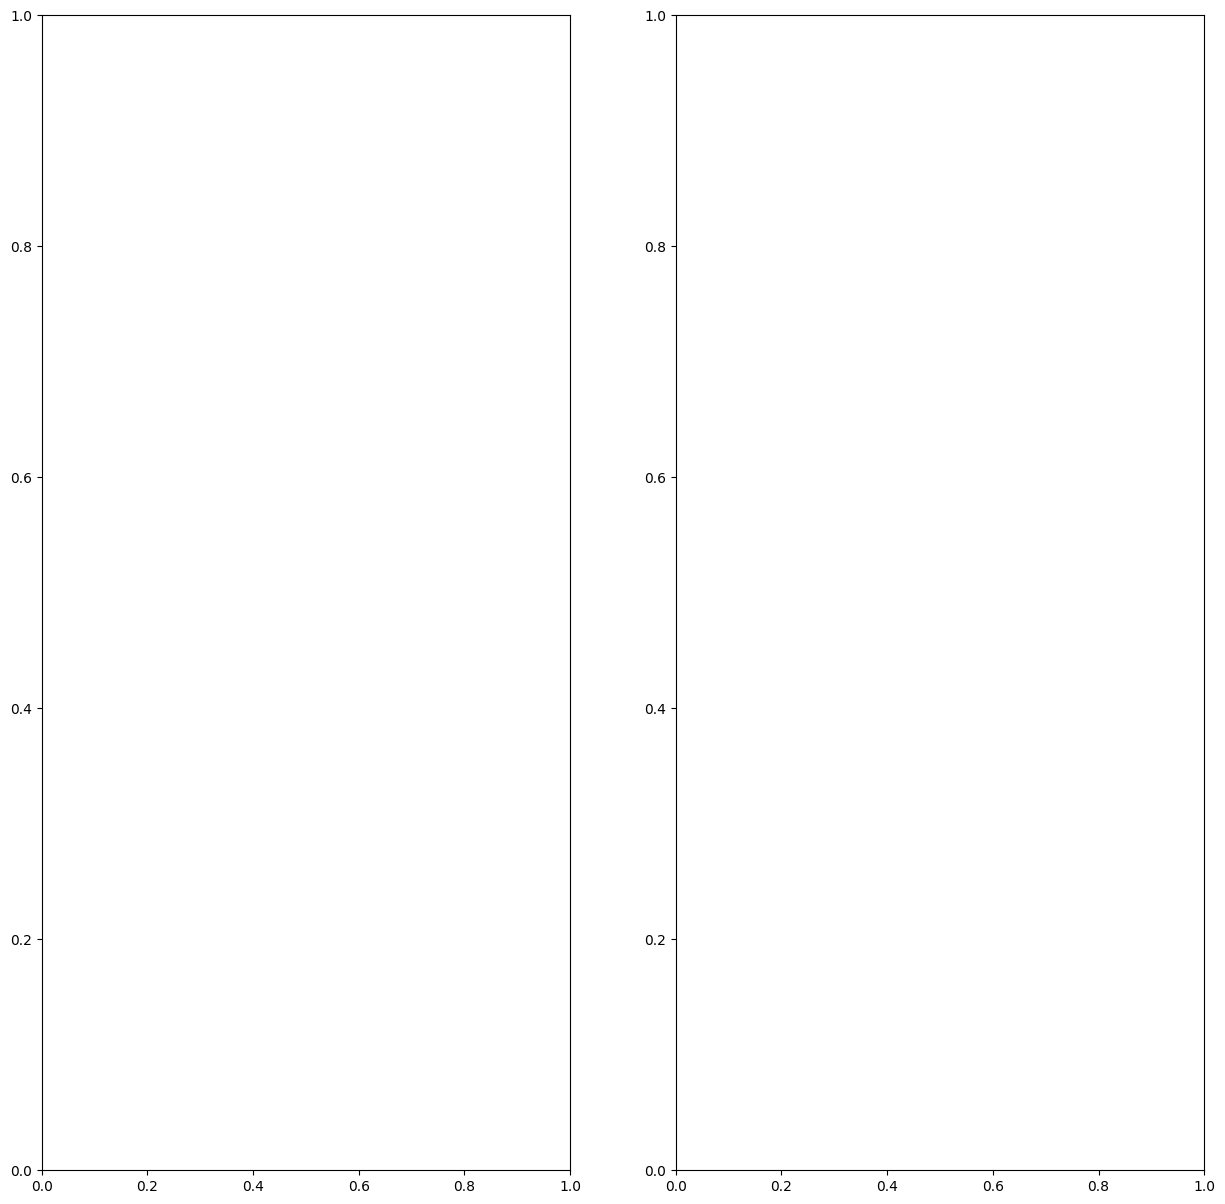

In [28]:
viewBatchPredictions(pred_images,gt_labels)

### Function to predict test dataset

In [40]:
def dataset_predictions(dataloader):
    pred_set=[]
    label_set=[]
    for batch in dataloader:
        images, labels = batch['pixel_values'], batch['labels']
        outputs = model(images, labels)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            #size of original image is 640x640
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted_mask = upsampled_logits.argmax(dim=1).numpy()
        labels = labels.numpy()
        pred_set.append(predicted_mask)
        label_set.append(labels)        
    return pred_set, label_set

In [41]:
pred_set, label_set= dataset_predictions(test_dataloader)

In [43]:
def savePredictions(pred_set, label_set, save_path):
    for i in range(len(pred_set)):
        file_name = f"result_{i}"
        n_plots = len(pred_set[i])
        from matplotlib import pyplot as plt
        f, axarr = plt.subplots(n_plots,2)
        f.set_figheight(15)
        f.set_figwidth(15)
        axarr[0,0].set_title("Predictions", {'fontsize': 30})
        axarr[0,1].set_title("Ground Truth", {'fontsize': 30})
        for j in range(n_plots):
            axarr[j,0].imshow(pred_set[i][j,:,:])
            axarr[j,1].imshow(label_set[i][j,:,:])
    
        # Construct the full path where the image will be saved
        file_path = os.path.join(save_path, f"{file_name}.png")
    
        # Save the figure
        plt.savefig(file_path, bbox_inches='tight')
        plt.close(f)  # Close the figure to free memory
    print("Predictions saved")
    

In [44]:
save_path='data_augmentation_dataset/outputs-7-Mar-lightning/'
savePredictions(pred_set, label_set, save_path)

Predictions saved
